<a href="https://colab.research.google.com/github/bushra-rafia/Bangla-Chatbot/blob/master/bidirectional_lstm_with_attention_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.optimizers import Adam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Concatenate, Dropout

**Load the cleaned dataset**

In [ ]:
df= pd.read_csv("/content/drive/MyDrive/CSE715-Project Group 6/Codebase/dataset/cleaned_dataset.csv")

In [ ]:
df.head()

,Queries,Response
0,এই যে,শুরু হাই আমি কীভাবে সাহায্য করতে পারি শেষ
1,হেলো,শুরু হ্যালো আমি আপনাকে কীভাবে সাহায্য করতে পার...
2,হ্যালো,শুরু হ্যালো আমি আপনার জন্য কী করতে পারি শেষ
3,হাই,শুরু হাই আমি আপনাকে কীভাবে সাহায্য করতে পারি শেষ
4,হে,শুরু হাই আমি আপনার জন্য কী করতে পারি শেষ


**Tokenizer**

In [ ]:
# get in one list
queries = df.Queries.astype(str).to_list()
response = df.Response.astype(str).to_list()

In [ ]:
def tokenizer(text):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(text)
  return tokenizer, tokenizer.texts_to_sequences(text)

In [ ]:
ques_tokenizer, ques_encoded= tokenizer(text= queries)
ans_tokenizer, ans_encoded= tokenizer(text= response)

In [ ]:
for resp in zip(response[:5]):
    print(resp)

for encoded in zip(ans_encoded[:5]):
    print(encoded)

('শুরু হাই আমি কীভাবে সাহায্য করতে পারি শেষ',)
('শুরু হ্যালো আমি আপনাকে কীভাবে সাহায্য করতে পারি শেষ',)
('শুরু হ্যালো আমি আপনার জন্য কী করতে পারি শেষ',)
('শুরু হাই আমি আপনাকে কীভাবে সাহায্য করতে পারি শেষ',)
('শুরু হাই আমি আপনার জন্য কী করতে পারি শেষ',)
([2, 298, 3, 155, 101, 9, 37, 1],)
([2, 228, 3, 28, 155, 101, 9, 37, 1],)
([2, 228, 3, 5, 12, 40, 9, 37, 1],)
([2, 298, 3, 28, 155, 101, 9, 37, 1],)
([2, 298, 3, 5, 12, 40, 9, 37, 1],)


**Get corresponding word mapping**

In [ ]:
# required for test phrase
ques_index_word = ques_tokenizer.index_word
ans_index_word= ans_tokenizer.index_word
ans_word_index =ans_tokenizer.word_index

In [ ]:
print(ques_tokenizer.word_counts)

OrderedDict([('এই', 624), ('যে', 652), ('হেলো', 4), ('হ্যালো', 61), ('হাই', 65), ('হে', 6), ('হায়', 3), ('কেমন', 533), ('আছো', 48), ('চলছে', 47), ('দিন', 130), ('কাল', 3), ('আপনি', 1657), ('আছেন', 55), ('কি', 3234), ('অবস্থা', 71), ('আপনার', 959), ('খবর', 46), ('তুমি', 326), ('ভাল', 354), ('করছেন', 119), ('আশা', 88), ('করি', 462), ('তোমার', 183), ('ভালো', 129), ('আমি', 2836), ('আছি', 29), ('নেই', 108), ('লাগছে', 55), ('না', 722), ('খারাপ', 63), ('ঠিক', 319), ('আছে', 533), ('ধন্যবাদ', 165), ('এটা', 590), ('সহায়ক', 4), ('বলতে', 131), ('চাচ্ছি', 3), ('তা', 271), ('বুঝতে', 29), ('পেরেছেন', 2), ('আমাকে', 326), ('বুঝেছ', 1), ('আমার', 910), ('কথা', 161), ('পারছেন', 1), ('বুঝা', 3), ('যাচ্ছে', 33), ('জানেন', 93), ('বলছি', 5), ('কী', 320), ('চাইছি', 3), ('বোঝার', 1), ('চেষ্টা', 143), ('করুন', 83), ('চুপ', 4), ('থাকো', 4), ('কর', 28), ('বন্ধ', 33), ('যথেষ্ট', 25), ('বলা', 57), ('অনুগ্রহ', 5), ('করে', 677), ('শান্ত', 13), ('হন', 39), ('বাই', 2), ('পরে', 95), ('দেখা', 189), ('হবে', 452), ('বিদায়

In [ ]:
print({key: ans_index_word[key] for key in list(ans_index_word.keys())[:5]})

{1: 'শেষ', 2: 'শুরু', 3: 'আমি', 4: 'আপনি', 5: 'আপনার'}


In [ ]:
print({key: ans_word_index[key] for key in list(ans_word_index.keys())[10:20]})

{'এটি': 11, 'জন্য': 12, 'না': 13, 'এটা': 14, 'সম্ভাবনা': 15, 'এবং': 16, 'আছে।': 17, 'আছে': 18, 'করি': 19, 'যে': 20}


**Vocabulary size**

In [ ]:
ANS_VOCAB_SIZE = len(ans_tokenizer.word_counts) + 1 # +1 reserved for an unknown word
ANS_VOCAB_SIZE

9190

In [ ]:
QUES_VOCAB_SIZE = len(ques_tokenizer.word_counts) + 1 # For zero padding we have added +1 in ques vocab size
QUES_VOCAB_SIZE

9234

**Find Max queries and response length**

In [ ]:
max_ques_len = 0
for i in range(len(ques_encoded)):
  if len(ques_encoded[i]) > max_ques_len:
    max_ques_len= len(ques_encoded[i])

max_ans_len = 0
for i in range(len(ans_encoded)):
  if len(ans_encoded[i]) > max_ans_len:
    max_ans_len= len(ans_encoded[i])
max_ans_len, max_ans_len

(30, 30)

**Padding**

In [ ]:
# Use max length for padding for ques and ans
ques_padded = pad_sequences(ques_encoded, maxlen=max_ques_len, padding='post')
ans_padded = pad_sequences(ans_encoded, maxlen=max_ans_len, padding='post')

In [ ]:
ans_padded

array([[   2,  298,    3, ...,    0,    0,    0],
       [   2,  228,    3, ...,    0,    0,    0],
       [   2,  228,    3, ...,    0,    0,    0],
       ...,
       [   2,   13,    1, ...,    0,    0,    0],
       [   2, 9188,    1, ...,    0,    0,    0],
       [   2,    3, 9189, ...,    0,    0,    0]], dtype=int32)

In [ ]:
ques_padded

array([[  15,   14,    0, ...,    0,    0,    0],
       [3535,    0,    0, ...,    0,    0,    0],
       [ 245,    0,    0, ...,    0,    0,    0],
       ...,
       [   3,    1, 1918, ...,    0,    0,    0],
       [  19, 1394,  468, ...,    0,    0,    0],
       [  19, 1394,  468, ...,    0,    0,    0]], dtype=int32)

**Train-Test splitting**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(ques_padded, ans_padded, test_size=0.10, random_state= 1000, shuffle =True)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11367, 30), (1264, 30), (11367, 30), (1264, 30))

**Attention Mechanism**

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    hidden_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

**Building Model**

**Encoder + Bidirectional LSTM**

In [ ]:
# Encoder
encoder_inputs = Input(shape=(max_ques_len,))
encoder_embedding = Embedding(QUES_VOCAB_SIZE, 1024)(encoder_inputs)

# Bidirectional LSTM layer
encoder_lstm = Bidirectional(LSTM(256, return_sequences=True, return_state=True))
encoder_outputs1, forw_state_h, forw_state_c, back_state_h, back_state_c = encoder_lstm(encoder_embedding)

# Taking states is  different in Bidirectional because,
# it has forward and backward states and have to consider both so We concatenate them.
final_enc_h = Concatenate()([forw_state_h,back_state_h])
final_enc_c = Concatenate()([forw_state_c,back_state_c])

# Now take only states and create context vector
encoder_states =[final_enc_h, final_enc_c]

**Decoder**

In [ ]:
# Decoder
decoder_inputs = Input(shape=(max_ans_len,))
dec_emb_layer = Embedding(ANS_VOCAB_SIZE, 1024)
decoder_embedding = dec_emb_layer(decoder_inputs)

# We used bidirectional layer above so we have to double units of this lstm
decoder_lstm = LSTM(256*2, return_sequences=True, return_state=True)
# just take output of this decoder dont need self states
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

**Attention Layer**

In [ ]:
# Attention Layer
attention_layer = BahdanauAttention(units=256)
context_vector, attention_weights = attention_layer(query = decoder_outputs, values = encoder_outputs1)

# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, context_vector])

**Dense Layer**

In [ ]:
# Dense layer
# here this is going to predicct so we can add dense layer here, we want to convert predicted numbers into probability so use softmax
decoder_dense = Dense(ANS_VOCAB_SIZE, activation='softmax')
# We will again feed predicted output into decoder to predict its next word
final_output = decoder_dense(decoder_concat_input)

In [ ]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], final_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 1024)             9455616   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 bidirectional (Bidirection  [(None, 30, 512),            2623488   ['embedding[0][0]']           
 al)                          (None, 256),                                                    

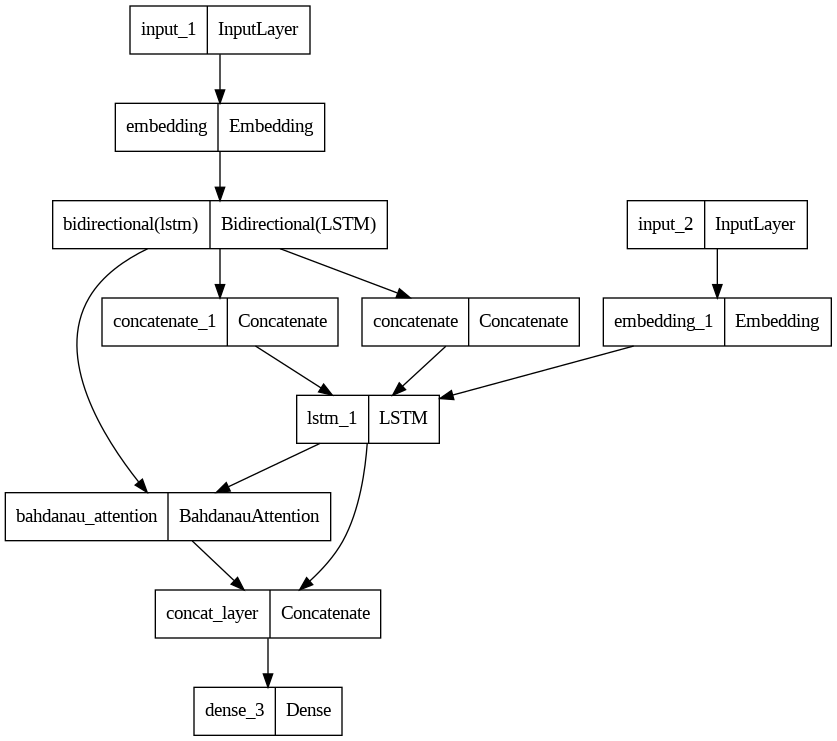

In [ ]:
plot_model(model)

**Optimizer**

In [ ]:
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

**EarlyStopping**

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

In [ ]:
# Training set
encoder_input_data = X_train
# To make same as target data skip last number which is just padding
decoder_input_data = y_train[:,:-1]
# Decoder target data has to be one step ahead so we are taking from 1 as told in keras docs
decoder_target_data = y_train[:,1:]

# Testing
encoder_input_test = X_test
decoder_input_test = y_test[:,:-1]
decoder_target_test= y_test[:,1:]


decoder_input_data = pad_sequences(decoder_input_data, maxlen=30)
decoder_target_data = pad_sequences(decoder_target_data, maxlen=30)
decoder_input_test = pad_sequences(decoder_input_test, maxlen=30)
decoder_target_test = pad_sequences(decoder_target_test, maxlen=30)

In [ ]:
history = model.fit([encoder_input_data, decoder_input_data],decoder_target_data,
                    epochs = 100,
                    batch_size = 64,
                    validation_data = ([encoder_input_test, decoder_input_test],decoder_target_test),
                    callbacks= [early_stopping]
                  )

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


178/178 [==============================] - 32s 169ms/step - loss: 1.4067 - accuracy: 0.8206 - val_loss: 1.1771 - val_accuracy: 0.8353
Epoch 2/100
178/178 [==============================] - 31s 175ms/step - loss: 1.0191 - accuracy: 0.8448 - val_loss: 1.1182 - val_accuracy: 0.8419
Epoch 3/100
178/178 [==============================] - 30s 169ms/step - loss: 0.8618 - accuracy: 0.8534 - val_loss: 1.1255 - val_accuracy: 0.8422
Epoch 4/100
178/178 [==============================] - 30s 170ms/step - loss: 0.7501 - accuracy: 0.8607 - val_loss: 1.1660 - val_accuracy: 0.8415
Epoch 5/100
178/178 [==============================] - 30s 168ms/step - loss: 0.6655 - accuracy: 0.8699 - val_loss: 1.2073 - val_accuracy: 0.8428
Epoch 6/100
178/178 [==============================] - 32s 177ms/step - loss: 0.6007 - accuracy: 0.8785 - val_loss: 1.2466 - val_accuracy: 0.8414
Epoch 7/100
178/178 [==============================] - 30s 168ms/step - loss: 0.5469 - accuracy: 0.8864 - val_loss: 1.2769 - val_accurac

**Save Model**

In [ ]:
model.save_weights("/content/drive/MyDrive/CSE715-Project Group 6/Codebase")

**Check for max accuracy**

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Get the index of the maximum validation accuracy
best_val_accuracy_index = val_accuracy.index(max(val_accuracy))

# Use the index to get the corresponding training accuracy
best_train_accuracy = train_accuracy[best_val_accuracy_index]

# Print the best training and validation accuracies
print("Training Accuracy:", best_train_accuracy)
print("Validation Accuracy:", max(val_accuracy))

Training Accuracy: 0.8990527987480164
Validation Accuracy: 0.8431698083877563


**Plot training & validation accuracy values**

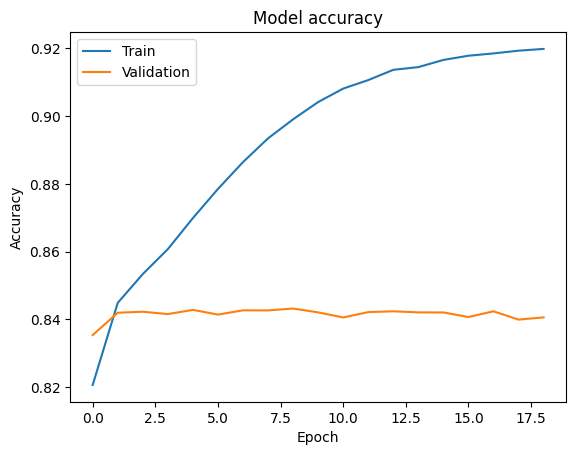

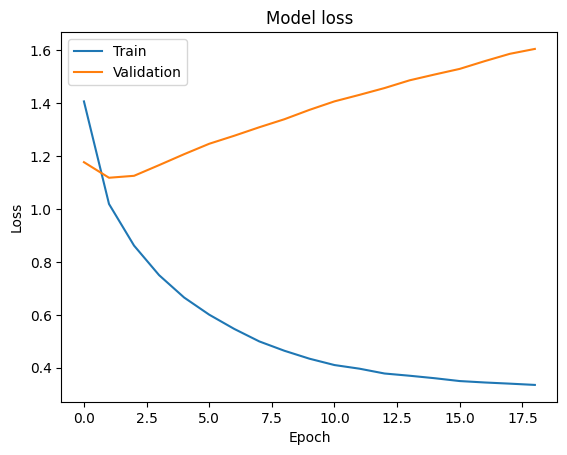

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


**Inference Model**

In [ ]:
Model = model.load_weights("/content/drive/MyDrive/CSE715-Project Group 6/model.h5")

In [ ]:
encoder_model = Model(encoder_inputs, outputs = [encoder_outputs1, final_enc_h, final_enc_c])

decoder_state_h = Input(shape=(512,))
decoder_state_c = Input(shape=(512,))
decoder_hidden_state_input = Input(shape=(30, 512))

dec_states = [decoder_state_h, decoder_state_c]

decoder_embedding = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(decoder_embedding, initial_state=dec_states)

attention_result_inf, attention_weights_inf = attention_layer(query = decoder_outputs2, values = decoder_hidden_state_input)
decoder_concat_input_inf = Concatenate(axis=-1, name='concat_layer')([decoder_outputs2, attention_result_inf])

dec_states2= [state_h2, state_c2]

decoder_outputs2 = decoder_dense(decoder_concat_input_inf)

decoder_model= Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_h, decoder_state_c],
                     [decoder_outputs2]+ dec_states2)

**Prediction**

In [ ]:
def get_predicted_sentence(input_seq):
    enc_output, enc_h, enc_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = ans_word_index['শুরু']
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [enc_output, enc_h, enc_c ])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
          break
        else:
            sampled_char = ans_index_word[sampled_token_index]

        if (sampled_char!='শেষ'):
            decoded_sentence += ' '+sampled_char
        if (sampled_char == 'শেষ' or len(decoded_sentence.split()) >= 36):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        enc_h, enc_c = h, c

    return decoded_sentence

In [ ]:
def get_response_sentence(sequence):
  sentence=""
  for i in sequence:
    if ((i != 0 and i != ans_word_index['শুরু']) and i != ans_word_index['শেষ']):
      sentence = sentence + ans_index_word[i]+' '
  return sentence

def get_ques_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i!=0:
        sentence =sentence +ques_index_word[i]+' '
    return sentence

In [ ]:
# for i in np.random.randint(10, 500, size=15):
#   print("Queries :",get_ques_sentence(X_test[i]))
#   print("Actual Sentence:",get_response_sentence(y_test[i]))
#   print("Predicted:",get_predicted_sentence(X_test[i].reshape(1,30)))
